
## A simple GAN to generate Images


In [42]:

import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random


In [43]:

import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split

from mlxtend.plotting import heatmap


In [44]:

from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim 
import torch.nn as nn


import torch.nn.functional as F

from torch.autograd import Variable



## Parameters


In [45]:

learning_rate    = 0.003  ## Adam default   ## 0.001
batch_size       = 32
N_Epochs         = 30  ##27000  



## Read the data


In [46]:

data_path = "MNISTdata/"


mnist_train = datasets.MNIST(data_path, train=True, download=True)


In [47]:

mnist_test = datasets.MNIST(data_path, train=False, download=True)


In [48]:

mnist_train_tr = datasets.MNIST(data_path, train=True, download=False, 
                                            transform=transforms.Compose([
                                                transforms.ToTensor()
                                            ]))
mnist_test_tr  = datasets.MNIST(data_path, train=False, download=False, 
                                            transform=transforms.Compose([
                                                transforms.ToTensor()
                                            ]))



## View the Images


In [49]:

Image.fromarray(  mnist_test_tr.data[333].numpy()  ) 


In [50]:

## mnist_train_tr.data = mnist_train_tr.data.view(60000, 1, 28, 28)

mnist_train_tr.data.shape


torch.Size([60000, 28, 28])


## Create Data Loaders


In [51]:

mnist_test_tr.data.shape


torch.Size([10000, 28, 28])

In [52]:

train_dl  = torch.utils.data.DataLoader(mnist_train_tr, batch_size=batch_size, shuffle=True  )

test_dl   = torch.utils.data.DataLoader(mnist_test_tr,  batch_size=batch_size, shuffle=False )



## Utility Functions


In [53]:

def plot_GAN_losses(list_losses_real, list_losses_fake, list_losses_tricked):
    
    the_epochs = [i for i in range(len(list_losses_real))]  

    plt.plot(the_epochs, list_losses_real,    label = "real") 
    plt.plot(the_epochs, list_losses_fake,    label = "fake") 
    plt.plot(the_epochs, list_losses_tricked, label = "tricked")
    plt.legend() 
    plt.show()


In [54]:

def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure, confmat


In [55]:

def plot_metric_per_epoch(the_scores_list):
    x_epochs = []
    y_epochs = [] 
    for i, val in enumerate(the_scores_list):
        x_epochs.append(i)
        y_epochs.append(val)
    
    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    plt.legend()
    plt.grid()
    plt.show()


In [56]:

def random_G_vector_input():
    rand_vec = torch.randn( 100 )
    return rand_vec


In [57]:

def random_G_batch_vector_input():
    rand_vec = torch.randn( (batch_size, 100 ) )
    return rand_vec


In [58]:

def random_batch_one_hot_rc(batch_size, size):
    rand_vec = torch.zeros( (batch_size, 10 ) )
    for i in range(batch_size):
        random_idx = random.randint(0,size-1)
        rand_vec[i, random_idx] = 1.0
    return rand_vec


In [59]:
'''

# size here must only be an integer
def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor
'''



'\n\n# size here must only be an integer\ndef generate_random_one_hot(size):\n    label_tensor = torch.zeros((size))\n    random_idx = random.randint(0,size-1)\n    label_tensor[random_idx] = 1.0\n    return label_tensor\n'

In [60]:

random_batch_one_hot_rc(32, 10)
 


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],



## NN Architectures


In [61]:

class Generator_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        

        self.linear1 = nn.Linear(100+10, 256)
        self.act1    = nn.LeakyReLU(0.02)
        self.norm1   = nn.LayerNorm(256)
        self.linear2 = nn.Linear(256, 784)
        self.act2    = nn.Sigmoid()
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, rand_input, label_tensor ):
        
        ## print(rand_input.shape)
        ## print(label_tensor.shape)

        inputs = torch.cat( ( rand_input , label_tensor) , dim=1)

        x      = self.linear1( inputs )
        x      = self.act1(x)
        x      = self.norm1(x) 
        x      = self.linear2(x)
        x      = self.act2(x)
        y_pred = x
        
        return y_pred


In [62]:

class Generator_DL_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        

        self.linear1 = nn.Linear(100, 60)
        self.act1    = nn.LeakyReLU(0.02)
        self.norm1   = nn.LayerNorm(60)
        self.linear2 = nn.Linear(60, 120)
        self.act2    = nn.LeakyReLU(0.02)
        self.norm2   = nn.LayerNorm(120)
        self.linear3 = nn.Linear(120, 784)
        self.act3    = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, rand_input ):
        

        x      = self.linear1( rand_input )
        x      = self.act1(x)
        x      = self.norm1(x) 
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.norm2(x) 
        x      = self.dropout(x)
        x      = self.linear3(x)
        x      = self.act3(x)
        
        y_pred = x
        
        return y_pred


In [63]:

class Discriminator_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(784+10, 100)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(100, 50)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(50, 1)
        self.act3    = nn.Sigmoid()             ## nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, x, label_tensor):
        
        inputs = torch.cat( (x, label_tensor) , dim=1)
        
        x      = self.linear1( inputs )
        x      = self.act1(x)
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.dropout(x)
        x      = self.linear3(x)
        y_pred = self.act3(x)
        
        return y_pred



## Training Function


In [64]:

list_losses_real    = []
list_losses_fake    = []
list_losses_tricked = []
    

def training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt   ):
    

    for epoch in range(N_Epochs):
        for xb, yb in train_dl:              ## xb = [batch, 1, 28, 28]
            
            xb = torch.squeeze(xb, dim=1)
            xb = xb.reshape((-1, 784))
            
            ## yb_one_hot = func( yb )
            yb = F.one_hot(yb, num_classes=10)
            ## print( yb.shape )
            ## input()
       
            #################################################
            
            ## G_model.eval()     ## No G training
            
            ## gen_img = G_model( random_G_vector_input() )
            
            rand_vector = random_batch_one_hot_rc(32, 10)
            
            gen_img = G_model( random_G_batch_vector_input(),  rand_vector ).detach()
            
            ## gen_labels = random_batch_one_hot(32, 10)
            
            ## Train D with real data
            D_real_y_pred = D_model(  xb, yb  )
            D_real_loss   = D_loss_fn( D_real_y_pred, torch.ones((batch_size, 1)) )
            D_opt.zero_grad()
            D_real_loss.backward()
            D_opt.step()
            
            ## Train D with fake data
            D_fake_y_pred = D_model(  gen_img,  rand_vector  )
            D_fake_loss   = D_loss_fn( D_fake_y_pred, torch.zeros((batch_size, 1)))
            D_opt.zero_grad()
            D_fake_loss.backward()
            D_opt.step()
            
            ## G_model.train()    ## yes G training
            
            #################################################
            
            ## D_model.eval()     ## No D training
            
            ## gen_img = G_model( random_G_vector_input() )
            
            rand_vector = random_batch_one_hot_rc(32, 10)
            
            gen_img = G_model( random_G_batch_vector_input(), rand_vector )
            
            ## Train G with D_loss (need to trick D)
            D_tricked_y_pred = D_model(  gen_img, rand_vector  )
            D_tricked_loss   = D_loss_fn( D_tricked_y_pred, torch.ones((batch_size, 1)) )
            G_opt.zero_grad()
            D_tricked_loss.backward()
            G_opt.step()
            
            ## D_model.train()    ## yes D training
                        
       
            
        if epoch % 1 == 0:
            print("******************************")
            print(epoch, "D_real_loss=", D_real_loss)
            print(epoch, "D_fake_loss=", D_fake_loss)
            print(epoch, "D_tricked_loss=", D_tricked_loss)
            list_losses_real.append(        D_real_loss.detach().numpy()  )
            list_losses_fake.append(        D_fake_loss.detach().numpy()  )
            list_losses_tricked.append(  D_tricked_loss.detach().numpy()  )
            



## Call the core functions


In [65]:

G_model     = Generator_Net()

## G_model     = Generator_DL_Net()

D_model     = Discriminator_Net()

## D_loss_fn   = nn.CrossEntropyLoss( )  
## D_loss_fn   = F.mse_loss

D_loss_fn   = nn.BCELoss()

G_opt       = torch.optim.Adam( G_model.parameters(), lr=learning_rate )
D_opt       = torch.optim.Adam( D_model.parameters(), lr=learning_rate )

training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt )


******************************
0 D_real_loss= tensor(0.0398, grad_fn=<BinaryCrossEntropyBackward0>)
0 D_fake_loss= tensor(0.1359, grad_fn=<BinaryCrossEntropyBackward0>)
0 D_tricked_loss= tensor(10.5246, grad_fn=<BinaryCrossEntropyBackward0>)
******************************
1 D_real_loss= tensor(0.0666, grad_fn=<BinaryCrossEntropyBackward0>)
1 D_fake_loss= tensor(0.0719, grad_fn=<BinaryCrossEntropyBackward0>)
1 D_tricked_loss= tensor(6.3613, grad_fn=<BinaryCrossEntropyBackward0>)
******************************
2 D_real_loss= tensor(0.1154, grad_fn=<BinaryCrossEntropyBackward0>)
2 D_fake_loss= tensor(0.0360, grad_fn=<BinaryCrossEntropyBackward0>)
2 D_tricked_loss= tensor(5.7520, grad_fn=<BinaryCrossEntropyBackward0>)
******************************
3 D_real_loss= tensor(0.1183, grad_fn=<BinaryCrossEntropyBackward0>)
3 D_fake_loss= tensor(0.1424, grad_fn=<BinaryCrossEntropyBackward0>)
3 D_tricked_loss= tensor(4.9916, grad_fn=<BinaryCrossEntropyBackward0>)
******************************
4 D_

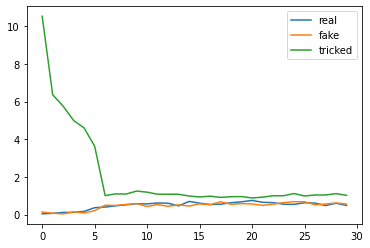

In [67]:

plot_GAN_losses(list_losses_real, list_losses_fake, list_losses_tricked)



## Test generating after training



## Inference CGAN


In [74]:

label = 9
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)
label_tensor.shape


torch.Size([1, 10])

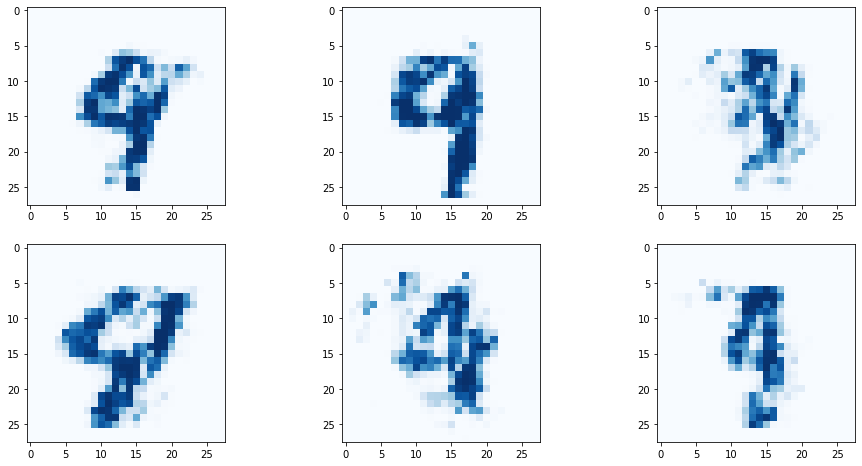

In [75]:

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0), label_tensor)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

      


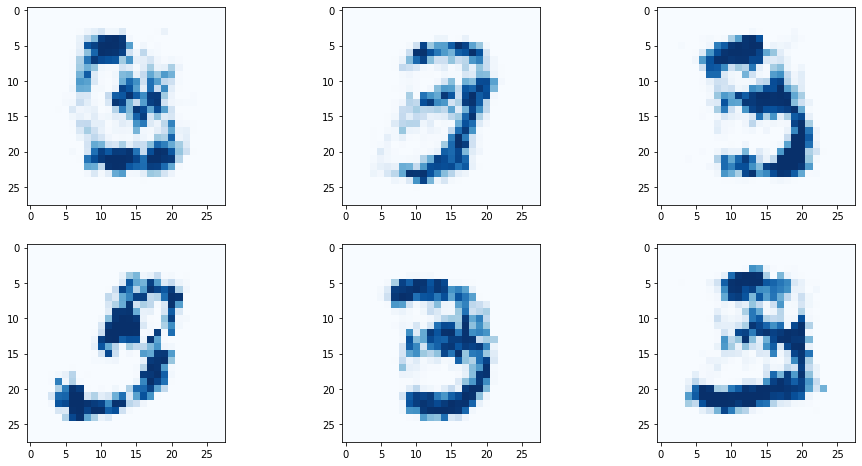

In [76]:

label = 3
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0), label_tensor)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

    


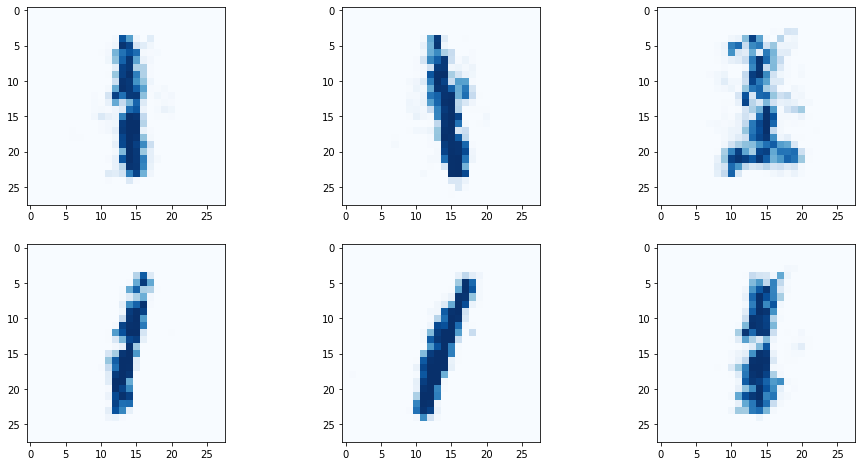

In [77]:


label = 1
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0), label_tensor)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

      


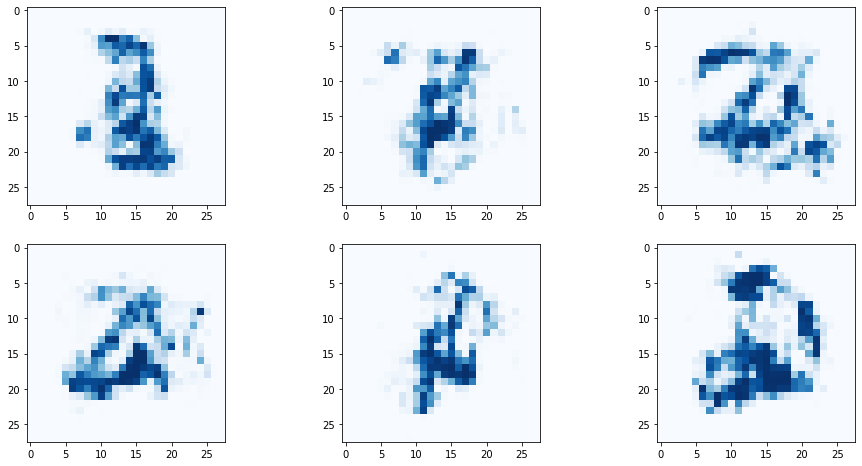

In [78]:

label = 2
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0), label_tensor)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

      


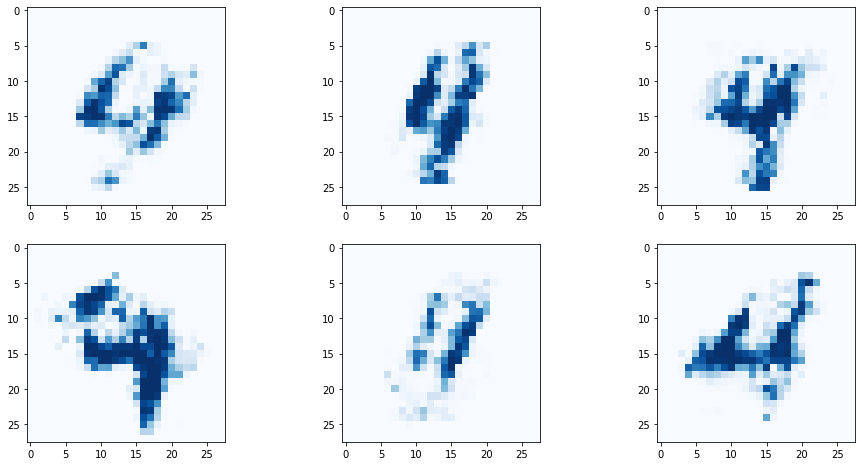

In [79]:

label = 4
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0), label_tensor)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

      


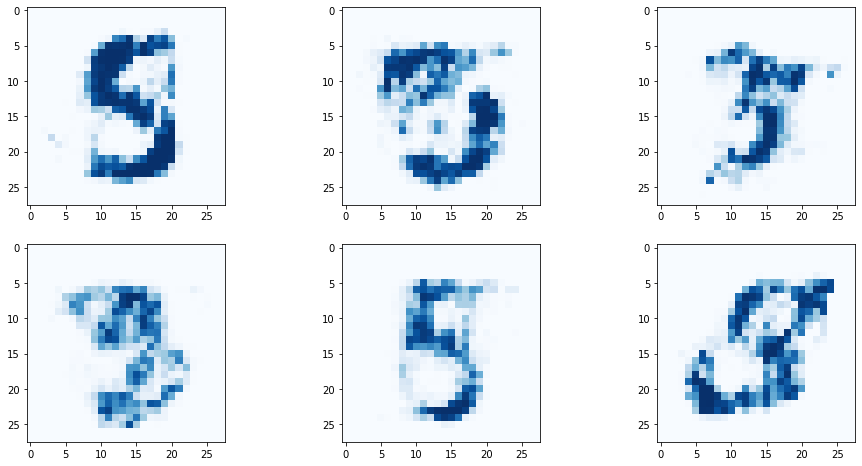

In [80]:

label = 5
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0), label_tensor)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

      


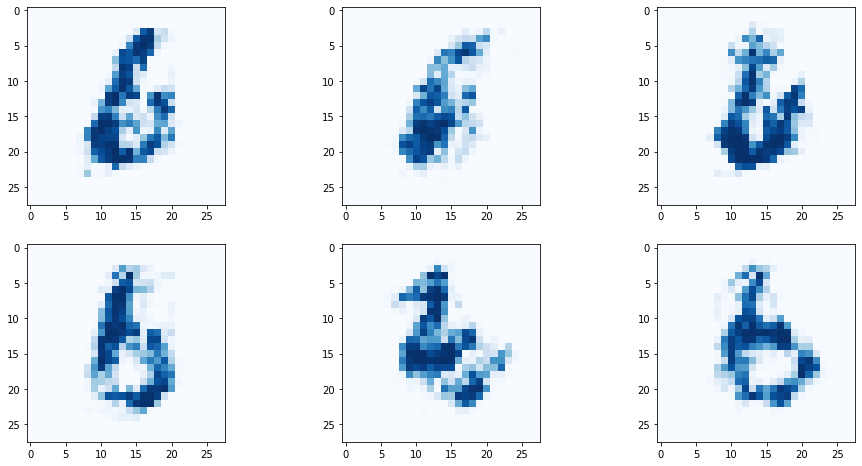

In [81]:

label = 6
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0), label_tensor)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

      


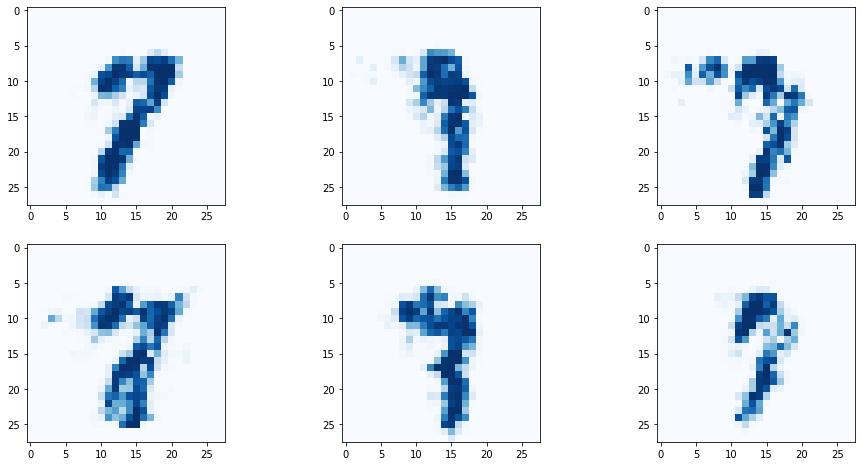

In [82]:

label = 7
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0), label_tensor)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

      


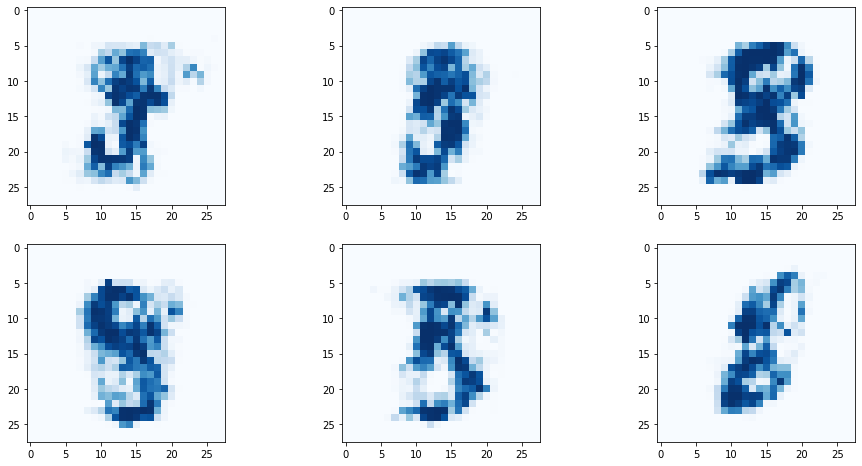

In [83]:

label = 8
        
label_tensor = torch.zeros((10))
label_tensor[label] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G_model.forward( random_G_vector_input().unsqueeze(0), label_tensor)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

      
